In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../Data/SAML-D.csv")
pd.set_option("display.max_columns",None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [4]:
df.shape

(9504852, 12)

In [5]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
std,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02
min,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00


Amount is highly skewed data due to the large difference between the mean (8,762.97) and max (12.6M), as well as the large standard deviation (25.6K).

Right skewed 
Since 75% of values are below 10K, but the max is 12.6M, a few large transactions stretch the scale.

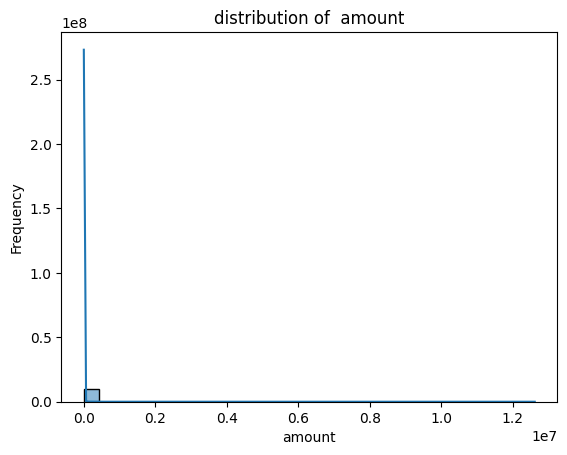

In [6]:
sns.histplot(df['Amount'],bins=30,kde=True)
plt.xlabel("amount")
plt.ylabel("Frequency")
plt.title("distribution of  amount")
plt.show()

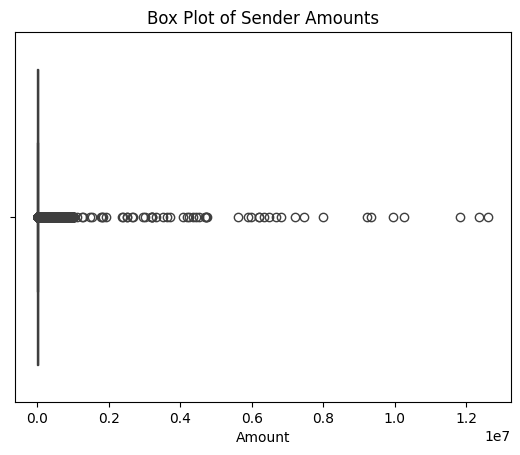

In [7]:
sns.boxplot(x=df['Amount'])
plt.title('Box Plot of Sender Amounts')
plt.show()


as predicted it has higher outliers and right skewness

also many outliers, it suggests a few high-risk transactions.

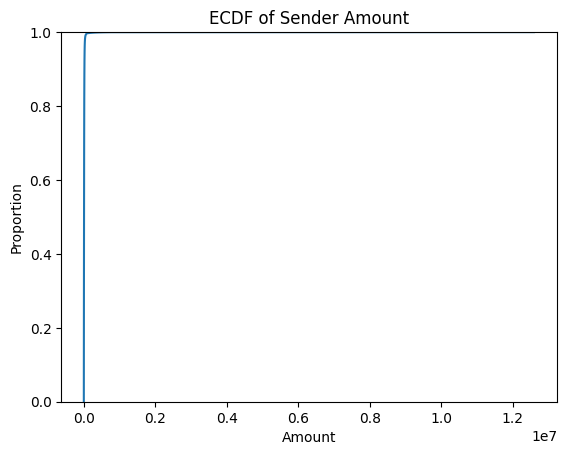

In [8]:
sns.ecdfplot(df['Amount'])
plt.title('ECDF of Sender Amount')
plt.show()


In [9]:
print(df['Amount'].quantile([0.25, 0.5, 0.75, 0.9, 0.99]))

0.25     2143.6875
0.50     6113.7200
0.75    10458.4625
0.90    16560.8500
0.99    45021.5482
Name: Amount, dtype: float64


The bulk of the transactions are below 10K, with the median being 6,113.72, and 75% of transactions are below 10.5K.</br>
At the 90th percentile, we're already at 16,560.85, indicating that the higher value transactions are becoming less frequent, but they still represent a significant portion of the data.</br>
The 99th percentile (45K) shows that only 1% of the transactions are larger than 45K. This means the majority of the data is heavily concentrated in smaller amounts.</br>

Large transactions in the 99th percentile could be flagged for review, but intermediate values between the 75th and 90th percentiles has a gradual increases (a sign of layering??).

There are many transactions around the 10K mark, it could also indicate smurfing.

Analysis for smurfing(structuring behaviours)

structuring behaviours: 6947862


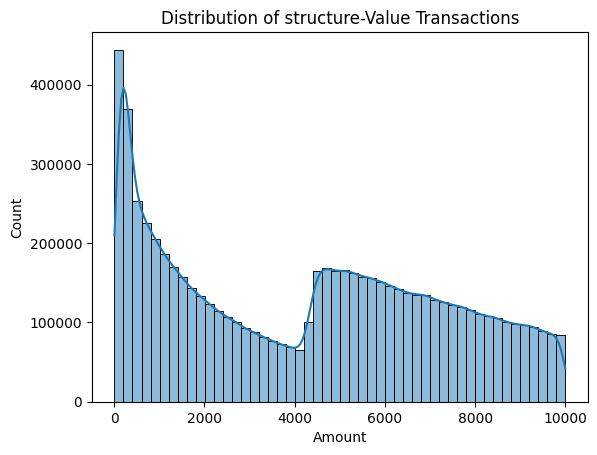

In [10]:

threshold = 10000 
structure_trans = df[df['Amount'] < threshold]

print(f"structuring behaviours: {len(structure_trans)}")
sns.histplot(structure_trans['Amount'], bins=50, kde=True)
plt.title('Distribution of structure-Value Transactions')
plt.show()

The bimodal distribution where data transactions tend to cluster around two separate ranges of amounts.

**First Peak (Low Amounts)**: The first peak is very prominent and occurs at the lower end of the amount range (around 0 to 1000). This indicates a high concentration of transactions with relatively small values.</br>
**Second Peak (Higher Amounts)**: The second peak is broader and occurs in the higher amount range (roughly 4500 to 10000). This suggests a significant number of transactions also fall within this higher range. </br>
**Dip in the Middle**: There's a noticeable dip or valley between the two peaks (around 3000 to 4500). This indicates a lower frequency of transactions within this middle range.</br>
**Right Skewness**: Overall, the distribution exhibits a right skew. This suggests the presence of some larger transactions, even though the majority are concentrated in the two peaks.

**Unusual Pattern**: The distinct dip in the middle of the distribution is somewhat unusual. It could indicate a specific characteristic of the system or a deliberate attempt to avoid transactions in that range.

In [11]:
structure_trans['Amount'].describe()

count    6.947862e+06
mean     4.268194e+03
std      3.022361e+03
min      3.730000e+00
25%      1.263390e+03
50%      4.520885e+03
75%      6.772080e+03
max      9.999990e+03
Name: Amount, dtype: float64

The majority of transactions are relatively small (below 6,772.08) and  there's a potential for smurfing activity within this dataset.

Suspicious Transactions: 2556986


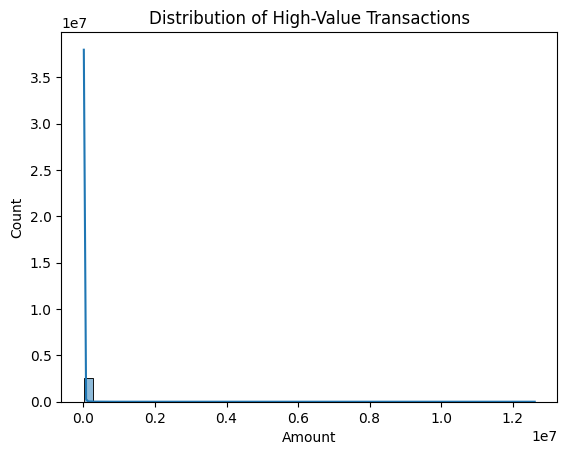

In [12]:
#suspecious transactions
threshold = 10000 
suspicious_trans = df[df['Amount'] > threshold]

print(f"Suspicious Transactions: {len(suspicious_trans)}")
sns.histplot(suspicious_trans['Amount'], bins=50, kde=True)
plt.title('Distribution of High-Value Transactions')
plt.show()

In [13]:
suspicious_trans['Amount'].describe()

count    2.556986e+06
mean     2.097620e+04
std      4.701147e+04
min      1.000001e+04
25%      1.181089e+04
50%      1.448360e+04
75%      1.956727e+04
max      1.261850e+07
Name: Amount, dtype: float64

**Investigate the Context**

Temporal Patterns using Date and time

The specific times of day or days of the week when these transactions are more frequent

In [14]:
structure_trans.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

In [15]:
structure_trans['Date'] = pd.to_datetime(structure_trans['Date'], format='%Y-%m-%d')
structure_trans['Date'].dt.year.unique()

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\2139535311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans['Date'] = pd.to_datetime(structure_trans['Date'], format='%Y-%m-%d')


array([2022, 2023], dtype=int32)

In [16]:
structure_trans['Time'] = pd.to_datetime(structure_trans['Time'],format="%H:%M:%S")
structure_trans['hours'] = structure_trans['Time'].dt.hour
structure_trans['hours']

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\2958010095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans['Time'] = pd.to_datetime(structure_trans['Time'],format="%H:%M:%S")
C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\2958010095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans['hours'] = structure_trans['Time'].dt.hour


0          10
1          10
4          10
5          10
7          10
           ..
9504846    10
9504847    10
9504848    10
9504849    10
9504851    10
Name: hours, Length: 6947862, dtype: int32

In [17]:
structure_trans.groupby('hours')['Sender_account']\
    .size().reset_index(name='count')\
    .sort_values(by='count', ascending=False).\
    reset_index(drop=True)

,hours,count
0,13,396676
1,10,396413
2,11,396131
3,14,396090
4,16,395983
5,9,395567
6,17,395539
7,8,395090
8,15,394842
9,12,394637


The busiest time of a  day is 1PM with the transaction 396676

but still The transaction counts are consistently very high across these peak hours

In [18]:
structure_trans.groupby(structure_trans['Date'].dt.month)['Sender_account'].size() \
    .reset_index(name='count_sender') \
    .sort_values(by='count_sender', ascending=False) \
    .reset_index(drop=True)

,Date,count_sender
0,5,669946
1,1,663802
2,3,663082
3,2,661942
4,11,661887
5,12,658653
6,7,658276
7,4,657810
8,6,652601
9,10,520501


there is no transaction  for the month of Sepetember in 2 years

checking for transaction greater then 10000

In [19]:
suspicious_trans['Date'] = pd.to_datetime(suspicious_trans['Date'], format='%Y-%m-%d')
suspicious_trans['Date'].dt.year.unique()

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\4187137544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_trans['Date'] = pd.to_datetime(suspicious_trans['Date'], format='%Y-%m-%d')


array([2022, 2023], dtype=int32)

In [20]:
suspicious_trans.groupby(suspicious_trans['Date'].dt.month)['Sender_account'].size() \
    .reset_index(name='count_sender') \
    .sort_values(by='count_sender', ascending=False) \
    .reset_index(drop=True)

,Date,count_sender
0,5,247655
1,3,245479
2,4,245072
3,6,244642
4,1,244517
5,7,243963
6,2,242863
7,12,241688
8,11,235734
9,10,188153


there is no records for the month of sep

may month in both the record has highest transactions

In [21]:
structure_trans_no = structure_trans[structure_trans['Is_laundering']==1]

In [22]:
structure_trans_no.groupby('hours')['Sender_account'].size() \
    .reset_index(name='count_sender_no_laundering') \
    .sort_values(by='count_sender_no_laundering', ascending=False) \
    .reset_index(drop=True)

,hours,count_sender_no_laundering
0,8,499
1,11,464
2,10,456
3,13,452
4,12,441
5,14,440
6,17,439
7,16,416
8,9,410
9,15,406


In [23]:
structure_trans_yes = structure_trans[structure_trans['Is_laundering']==0]
structure_trans_yes.groupby('hours')['Sender_account'].size() \
    .reset_index(name='count_sender_yes_laundering') \
    .sort_values(by='count_sender_yes_laundering', ascending=False) \
    .reset_index(drop=True)

,hours,count_sender_yes_laundering
0,13,396224
1,10,395957
2,11,395667
3,14,395650
4,16,395567
5,9,395157
6,17,395100
7,8,394591
8,15,394436
9,12,394196


**Potential Money Laundering Patterns** </br>
*Overlap with Business Hours*:</br>

Both laundering and non-laundering transactions peak during business hours (8 AM - 5 PM). </br>
*Laundering activity slightly favors* morning hours (8-11 AM), which could indicate attempts to blend with legitimate business transactions.</br>
**Drop in Illicit Transactions in Early Morning**:</br>
Night-Time Transactions (10 PM - 12 AM) Show Higher Laundering Ratios


In [24]:
structure_trans_yes.groupby(structure_trans_yes['Date'].dt.month)['Sender_account'].size() \
    .reset_index(name='count_sender_yes_laundering') \
    .sort_values(by='count_sender_yes_laundering', ascending=False) \
    .reset_index(drop=True)

,Date,count_sender_yes_laundering
0,5,669317
1,1,663098
2,3,662393
3,2,661260
4,11,661252
5,12,657977
6,7,657522
7,4,657097
8,6,651808
9,10,519961


most of the laundering transactions are peak at may,january,march which is start of the year

In [25]:
structure_trans_no.groupby(structure_trans_no['Date'].dt.month)['Sender_account'].size() \
    .reset_index(name='count_sender_no_laundering') \
    .sort_values(by='count_sender_no_laundering', ascending=False) \
    .reset_index(drop=True)

,Date,count_sender_no_laundering
0,6,793
1,7,754
2,4,713
3,1,704
4,3,689
5,2,682
6,12,676
7,8,662
8,11,635
9,5,629


***Peak Months for Suspected Money Laundering Transactions**:</br>

The highest volume of transactions (laundering) occurs in May (669,317 transactions), followed by January (663,098) and March (662,393).
The lowest recorded activity is in August (478,700 transactions) and October (519,961 transactions).
Since  May is the busiest month for regular transactions, and increasing in laundering cases (629).
</br>

**Peak Months for Non-Laundering Transactions**: </br>
The highest  non money laundering activity occurs in June (793 transactions), followed by July (754) and April (713).
</br>

**Seasonal Trends & Possible Explanations** </br>

During December holidays and summer vacations (may-June-July), legitimate businesses see a rise in transactions, making it easier for criminals to blend illegal money into the system without triggering alarms. </br>
**Year-End Drop** High laundering cases in January and May, both critical periods for financial audits and tax filings</br>
**Mismatch with Normal Transactions**: Money laundering transactions peak in may, while legitimate transactions peak in June.

Sender_account and Receiver_account

Analyzing the frequency of interactions between specific sender and receiver accounts

In [26]:
structure_trans.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'hours'],
      dtype='object')

In [27]:
structure_trans['month'] = structure_trans['Date'].dt.month
monthly_interaction_counts = structure_trans.groupby(['Sender_account','Receiver_account','month']).\
    size().reset_index(name='total_interaction').\
    sort_values(by = 'total_interaction',ascending = False).reset_index(drop = True)

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\2684579488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans['month'] = structure_trans['Date'].dt.month


In [28]:
print(monthly_interaction_counts.head()) 

   Sender_account  Receiver_account  month  total_interaction
0      9999156867        6426501951      5                 13
1      9999156867        4748985914      5                 13
2      9999156867        3771576970      5                 13
3      2674992774        2453302034      1                 13
4      2674992774        1835746265      1                 13


In [29]:
monthly_interaction_pivot = monthly_interaction_counts.pivot_table(
    index=['Sender_account', 'Receiver_account'], 
    columns='month', 
    values='total_interaction',
    fill_value=0
    )


print(monthly_interaction_pivot)  

month                              1    2    3     4     5     6    7     8   \
Sender_account Receiver_account                                                
9018           2388293593         0.0  0.0  0.0   0.0   0.0   0.0  1.0   0.0   
28511          3072405466         1.0  1.0  1.0   1.0   1.0   1.0  1.0   0.0   
32095          6045686021         0.0  0.0  0.0  12.0   0.0   0.0  0.0   0.0   
58673          6527756886         0.0  0.0  0.0   0.0   1.0   0.0  0.0   0.0   
61549          3951053115         0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0   
...                               ...  ...  ...   ...   ...   ...  ...   ...   
9999765876     5904197157         0.0  0.0  0.0   0.0  12.0   0.0  0.0   0.0   
9999766666     8866052676         0.0  0.0  0.0   0.0   0.0   0.0  0.0  12.0   
9999862026     9138131872        12.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0   
9999913136     7860186083         0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0   
9999986843     2812722257         0.0  0

In [30]:
structure_trans_no['month'] = structure_trans_no['Date'].dt.month
structure_trans_no.groupby(['Sender_account','Receiver_account','month']).\
    size().reset_index(name='total_interaction').\
    sort_values(by = 'total_interaction',ascending = False).reset_index(drop = True)

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\2179901361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans_no['month'] = structure_trans_no['Date'].dt.month


,Sender_account,Receiver_account,month,total_interaction
0,7092670704,618621750,8,10
1,3990750333,5988790750,5,10
2,6944121116,4796599250,3,10
3,1253336976,8371675450,6,10
4,4610869511,4349270455,1,10
...,...,...,...,...
5547,9990989594,1171302146,5,1
5548,9990989594,2206255345,6,1
5549,9992249143,5980835605,12,1
5550,9992526432,9254521765,4,1


In [31]:
structure_trans_yes['month'] = structure_trans_yes['Date'].dt.month
structure_trans_yes.groupby(['Sender_account','Receiver_account','month']).\
    size().reset_index(name='total_interaction').\
    sort_values(by = 'total_interaction',ascending = False).reset_index(drop = True)

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\3777363617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structure_trans_yes['month'] = structure_trans_yes['Date'].dt.month


,Sender_account,Receiver_account,month,total_interaction
0,9139245827,350036863,6,13
1,9138741146,7192659347,2,13
2,898248848,1812880210,5,13
3,898248848,2094971450,5,13
4,9138741146,5169852013,2,13
...,...,...,...,...
2494344,5097366129,9229400051,10,1
2494345,5097366129,9229400051,4,1
2494346,5097366129,7979349153,10,1
2494347,5097366129,7979349153,8,1


the number of transaction made by each account in an hours

In [32]:

structure_trans.groupby(['Sender_account','hours']).\
    size().reset_index(name='total_interaction').\
    sort_values(by = 'total_interaction',ascending = False).reset_index(drop = True)

,Sender_account,hours,total_interaction
0,8913863501,11,56
1,1695584314,10,55
2,7698046407,14,55
3,6162961822,19,53
4,6408343900,9,53
...,...,...,...
1703155,61549,18,1
1703156,61549,19,1
1703157,9999862026,23,1
1703158,9999913136,8,1


In [33]:

structure_trans.groupby(['Sender_account','month']).\
    size().reset_index(name='total_interaction_by_month').\
    sort_values(by = 'total_interaction_by_month',ascending = False).reset_index(drop = True)

,Sender_account,month,total_interaction_by_month
0,4950155721,4,279
1,637737742,11,270
2,717100283,1,263
3,9087331330,4,260
4,7823743088,10,259
...,...,...,...
587051,7022084044,4,1
587052,7021982768,11,1
587053,9999724248,12,1
587054,9999724248,6,1


In [34]:

structure_trans_no.groupby(['Sender_account','month']).\
    size().reset_index(name='total_interaction_by_month').\
    sort_values(by = 'total_interaction_by_month',ascending = False).reset_index(drop = True)

,Sender_account,month,total_interaction_by_month
0,4159678387,8,10
1,6944121116,3,10
2,1383474815,4,10
3,208056103,1,10
4,9586816158,10,10
...,...,...,...
4258,9990989594,5,1
4259,1487922912,12,1
4260,9992249143,12,1
4261,9992526432,4,1


In [35]:
structure_trans_yes.groupby(['Sender_account','month']).\
    size().reset_index(name='total_interaction_by_month').\
    sort_values(by = 'total_interaction_by_month',ascending = False).reset_index(drop = True)

,Sender_account,month,total_interaction_by_month
0,4950155721,4,279
1,637737742,11,270
2,717100283,1,263
3,9087331330,4,260
4,7823743088,10,259
...,...,...,...
585161,432973,8,1
585162,155434,7,1
585163,28511,6,1
585164,4323439123,2,1


 frequent small transactions by the account

In [36]:

structure_trans.groupby(['Sender_account', 'month']).agg(
    transaction_count=('Amount', 'count'), 
    total_amount_sent=('Amount', 'sum')     
).reset_index().sort_values(by='transaction_count',ascending=False)


,Sender_account,month,transaction_count,total_amount_sent
289652,4950155721,4,279,1648402.56
37213,637737742,11,270,1657676.07
41666,717100283,1,263,1786977.44
532965,9087331330,4,260,1480539.70
458145,7823743088,10,259,1697265.89
...,...,...,...,...
411475,7022084044,4,1,4382.29
411472,7021982768,11,1,205.46
587050,9999724248,12,1,1176.46
587048,9999724248,6,1,887.80


In [37]:
structure_trans_no.groupby(['Sender_account', 'month']).agg(
    transaction_count=('Amount', 'count'), 
    total_amount_sent=('Amount', 'sum')     
).reset_index().sort_values(by='transaction_count',ascending=False)

,Sender_account,month,transaction_count,total_amount_sent
1764,4159678387,8,10,1500.50
2973,6944121116,3,10,1622.59
548,1383474815,4,10,1416.76
83,208056103,1,10,1611.24
4070,9586816158,10,10,1354.97
...,...,...,...,...
4258,9990989594,5,1,7925.66
585,1487922912,12,1,4298.88
4260,9992249143,12,1,4477.64
4261,9992526432,4,1,4004.44


In [38]:
structure_trans_yes.groupby(['Sender_account', 'month']).agg(
    transaction_count=('Amount', 'count'), 
    total_amount_sent=('Amount', 'sum')     
).reset_index().sort_values(by='transaction_count',ascending=False)

,Sender_account,month,transaction_count,total_amount_sent
288710,4950155721,4,279,1648402.56
37098,637737742,11,270,1657676.07
41536,717100283,1,263,1786977.44
531255,9087331330,4,260,1480539.70
456661,7823743088,10,259,1697265.89
...,...,...,...,...
57,432973,8,1,9646.15
26,155434,7,1,124.89
6,28511,6,1,6197.07
252003,4323439123,2,1,905.01


In [39]:
structure_trans.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'hours', 'month'],
      dtype='object')

Analyzing the geographic distribution of sender and receiver banks.

the sender bank location having highest transaction amount

In [40]:
structure_trans.groupby('Sender_bank_location')['Amount'].sum().\
    reset_index(name='toal_amount').\
    sort_values(by='toal_amount',ascending=False).\
    reset_index(drop=True)

,Sender_bank_location,toal_amount
0,UK,2.851692e+10
1,Pakistan,7.477901e+07
2,Nigeria,7.351929e+07
3,USA,7.133883e+07
4,Turkey,7.127414e+07
5,Germany,7.118381e+07
6,Switzerland,7.087174e+07
7,UAE,7.031696e+07
8,Spain,6.912358e+07
9,Morocco,6.621622e+07


In [41]:
structure_trans.groupby(['Sender_bank_location','Receiver_bank_location'])['Amount'].sum().\
    reset_index(name='toal_amount').\
    sort_values(by='toal_amount',ascending=False).\
    reset_index(drop=True)

,Sender_bank_location,Receiver_bank_location,toal_amount
0,UK,UK,2.634355e+10
1,UK,Morocco,1.366986e+08
2,UK,France,1.354220e+08
3,UK,Japan,1.332147e+08
4,UK,Germany,1.321983e+08
...,...,...,...
319,Netherlands,Mexico,5.165552e+04
320,Italy,Italy,5.006980e+04
321,Italy,India,3.672703e+04
322,Netherlands,Germany,2.836564e+04


In [42]:
structure_trans_yes.groupby(['Sender_bank_location','Receiver_bank_location'])['Amount'].sum().\
    reset_index(name='toal_amount').\
    sort_values(by='toal_amount',ascending=False).\
    reset_index(drop=True)

,Sender_bank_location,Receiver_bank_location,toal_amount
0,UK,UK,2.632256e+10
1,UK,Morocco,1.358835e+08
2,UK,France,1.351447e+08
3,UK,Japan,1.329588e+08
4,UK,Germany,1.318503e+08
...,...,...,...
319,Netherlands,Mexico,5.165552e+04
320,Italy,Italy,5.006980e+04
321,Italy,India,3.672703e+04
322,Netherlands,Germany,2.836564e+04


In [43]:
structure_trans_no.groupby(['Sender_bank_location','Receiver_bank_location'])['Amount'].sum().\
    reset_index(name='toal_amount').\
    sort_values(by='toal_amount',ascending=False).\
    reset_index(drop=True)

,Sender_bank_location,Receiver_bank_location,toal_amount
0,UK,UK,2.099027e+07
1,UK,Morocco,8.151804e+05
2,UK,Albania,7.738769e+05
3,UK,Nigeria,6.913466e+05
4,UK,Turkey,5.889831e+05
...,...,...,...
100,France,Albania,3.110630e+03
101,Japan,France,3.013090e+03
102,Albania,Albania,2.800750e+03
103,USA,Nigeria,2.585527e+03


The UK is known for having massive banking transactions due to its status as a global financial hub, attracting significant investment and financial activity from around the world.

checking the amount deposited by each sender_account

In [44]:
structure_trans['Payment_type'].value_counts()

Payment_type
Debit card         1449795
Credit card        1449428
Cheque             1449141
ACH                1446775
Cross-border        627189
Cash Withdrawal     300477
Cash Deposit        225057
Name: count, dtype: int64

In [45]:
cash_deposit = structure_trans[structure_trans['Payment_type']=='Cash Deposit']

In [46]:
cash_deposit['year'] = cash_deposit['Date'].dt.year

C:\Users\lang-chain\AppData\Local\Temp\ipykernel_9776\1171581784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cash_deposit['year'] = cash_deposit['Date'].dt.year


In [47]:
cash_deposit['year']

0          2022
4          2022
11         2022
29         2022
53         2022
           ... 
9504820    2023
9504826    2023
9504829    2023
9504836    2023
9504841    2023
Name: year, Length: 225057, dtype: int32

In [48]:
cash_deposit_2022=cash_deposit[cash_deposit['year']==2022]

In [49]:
cash_deposit_2022.groupby(['Sender_account','month'])['Amount'].sum().\
    reset_index(name="total_amount_deposited").sort_values(by = 'total_amount_deposited',ascending=False).\
    reset_index(drop=True)

,Sender_account,month,total_amount_deposited
0,9862053017,12,31210.25
1,9003897341,10,25877.07
2,3187084517,11,25778.62
3,5004625051,11,23748.07
4,5262095561,10,23275.05
...,...,...,...
37239,7039019427,10,53.44
37240,6563103759,12,53.39
37241,6679743759,10,51.34
37242,5851624890,11,51.12


In [50]:
cash_deposit_2023=cash_deposit[cash_deposit['year']==2023]
cash_deposit_2023.groupby(['Sender_account','month'])['Amount'].sum().\
    reset_index(name="total_amount_deposited").sort_values(by = 'total_amount_deposited',ascending=False).\
    reset_index(drop=True)

,Sender_account,month,total_amount_deposited
0,3837607024,1,31316.95
1,6700207226,4,27763.98
2,2488893433,1,26691.91
3,4503049074,8,26040.67
4,8394329540,8,25771.32
...,...,...,...
101881,6199527160,1,53.31
101882,727166272,4,51.36
101883,809977712,3,51.04
101884,7704747964,5,50.31


In [51]:
cash_deposit_2023_yes = cash_deposit_2023[cash_deposit_2023['Is_laundering']==0]
cash_deposit_2023_no =  cash_deposit_2023[cash_deposit_2023['Is_laundering']==1]

In [52]:
cash_deposit_2023_yes.groupby(['Sender_bank_location','month'])['Amount'].sum().reset_index()

,Sender_bank_location,month,Amount
0,UK,1,45305111.35
1,UK,2,45549265.98
2,UK,3,47393969.16
3,UK,4,42170698.97
4,UK,5,47379129.82
5,UK,6,46663066.32
6,UK,7,43624829.42
7,UK,8,33993711.45


In [53]:
cash_deposit_2022_yes = cash_deposit_2022[cash_deposit_2022['Is_laundering']==0]
cash_deposit_2022_no =  cash_deposit_2022[cash_deposit_2022['Is_laundering']==1]

cash_deposit_2022_yes.groupby(['Sender_bank_location','month'])['Amount'].sum().reset_index()

,Sender_bank_location,month,Amount
0,UK,10,34265963.50
1,UK,11,47095411.00
2,UK,12,45414503.34


In [54]:
cash_deposit['Receiver_bank_location'].value_counts()

Receiver_bank_location
UK         225052
Austria         5
Name: count, dtype: int64

In [55]:
cash_deposit['Sender_bank_location'].value_counts()

Sender_bank_location
UK    225057
Name: count, dtype: int64

In [56]:
cash_deposit.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'hours', 'month', 'year'],
      dtype='object')

In [57]:
cash_deposit['Laundering_type'].value_counts()

Laundering_type
Normal_Cash_Deposits    223801
Smurfing                   932
Deposit-Send               324
Name: count, dtype: int64

In [58]:
structure_trans['Payment_type'].value_counts()

Payment_type
Debit card         1449795
Credit card        1449428
Cheque             1449141
ACH                1446775
Cross-border        627189
Cash Withdrawal     300477
Cash Deposit        225057
Name: count, dtype: int64

cross border transfer

In [60]:
inter_country_trans = structure_trans[structure_trans['Payment_type'] == 'Cross-border']
inter_country_laundering_yes = inter_country_trans[inter_country_trans['Is_laundering'] == '0']
inter_country_trans = inter_country_trans.reset_index(drop=True)
inter_country_trans[['Sender_account', 'Receiver_account', 
                           'Sender_bank_location', 'Receiver_bank_location', 
                           'Amount', 'Is_laundering']].head()

,Sender_account,Receiver_account,Sender_bank_location,Receiver_bank_location,Amount,Is_laundering
0,1491989064,8401255335,UK,UAE,6019.64,0
1,7017008854,3714297114,UK,Spain,1971.15,0
2,2047410771,6646502650,UK,France,8110.72,0
3,1203252958,8500212178,UK,Mexico,2438.30,0
4,3510078932,8722924810,UK,Albania,8067.61,0


In [61]:
structure_trans['Payment_type'].value_counts()

Payment_type
Debit card         1449795
Credit card        1449428
Cheque             1449141
ACH                1446775
Cross-border        627189
Cash Withdrawal     300477
Cash Deposit        225057
Name: count, dtype: int64

What types of laundering are most prevelant in the data set?

In [62]:
laundering_counts = structure_trans['Laundering_type'].value_counts().reset_index()
laundering_counts.columns = ['Laundering_type', 'Count']
print(laundering_counts)

           Laundering_type    Count
0     Normal_Small_Fan_Out  3005429
1           Normal_Fan_Out  1446842
2            Normal_Fan_In  1218577
3             Normal_Group   455189
4   Normal_Cash_Withdrawal   305031
5     Normal_Cash_Deposits   223801
6        Normal_Periodical   176272
7       Normal_Plus_Mutual    61669
8            Normal_Foward    30509
9            Normal_Mutual    17066
10             Structuring     1833
11         Cash_Withdrawal     1334
12                Smurfing      932
13            Deposit-Send      646
14         Layered_Fan_Out      384
15    Behavioural_Change_1      333
16       Stacked Bipartite      326
17          Layered_Fan_In      308
18    Behavioural_Change_2      296
19               Bipartite      223
20          Scatter-Gather      218
21          Gather-Scatter      213
22                  Fan_In      211
23                 Fan_Out      135
24                   Cycle       85


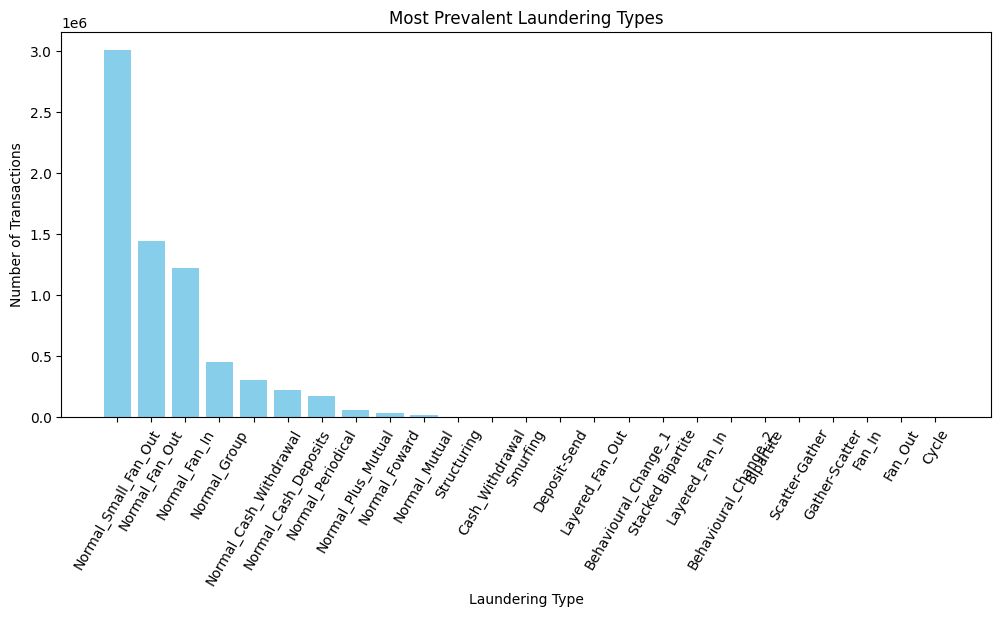

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(laundering_counts['Laundering_type'], laundering_counts['Count'], color='skyblue')
plt.xlabel('Laundering Type')
plt.ylabel('Number of Transactions')
plt.title('Most Prevalent Laundering Types')
plt.xticks(rotation=60)
plt.show()
